In [1]:
# tested in transformers==4.18.0 
from transformers import BertTokenizer,BertForSequenceClassification, BertConfig, pipeline, utils
from tqdm import tqdm
import torch
import os
import pandas as pd

In [3]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
config = BertConfig.from_pretrained('yiyanghkust/finbert-tone')

/Users/asabuncuoglu/Documents/faid-test-financial-sentiment-analysis/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
pipe = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

In [5]:
df = pd.read_csv("hf://datasets/kdave/Indian_Financial_News/training_data_26000.csv")

In [6]:
df.head()

,URL,Content,Summary,Sentiment
0,https://www.moneycontrol.com/news/business/eco...,US consumer spending dropped by a record in Ap...,consumer spending plunges 13.6 percent in Apri...,Negative
1,https://www.businesstoday.in/top-story/state-r...,State-run lenders require an urgent Rs 1.2 tri...,government will have to take a bulk of the tab...,Negative
2,https://www.financialexpress.com/economy/covid...,Apparel exporters on Wednesday urged the gover...,exporters are facing issues in terms of raw ma...,Negative
3,https://www.moneycontrol.com/news/business/mar...,Asian shares battled to extend a global reboun...,the dollar loses some ground on the safe haven...,Negative
4,https://www.financialexpress.com/industry/six-...,After India’s sovereign credit rating fell to ...,six Indian public-sector undertakings have tak...,Negative


In [8]:
print(df["Summary"][:100].to_list())

['consumer spending plunges 13.6 percent in April. that was the biggest drop since the government started tracking series in 1959. consumer spending accounts for more than two-thirds of economic activity. economists polled by Reuters had forecast consumer spending plummeting 12.6 percent. a spokesman for the u.s. government said the data was not available.', 'government will have to take a bulk of the tab due to weak market valuations, report says. this is more than double the budgeted Rs 53,000-crore of capital infusion for current fiscal year. government has already used up over 95 per cent of the deficit target or the market borrowings. report comes as the government is asking the Reserve Bank to lower the minimum capital requirements.', 'exporters are facing issues in terms of raw material supply on account of the coronavirus outbreak. some export promotion schemes allow import of machines and raw materials used to make exportable products at zero duty but with an export obligation

In [2]:
out_file = "../../data/output/indian/predictions.csv"

In [7]:
data = {'y_true': [], 'y_pred': []}
pred_df = pd.DataFrame(data)

pred = pipe(df['Summary'].to_list())

y_pred = [p['label'] for p in pred]
y_true = df["Sentiment"].to_list()

pred_df["y_true"] = y_true
pred_df["y_pred"] = y_pred

pred_df.to_csv(out_file, index=False)

In [10]:
pred_df.value_counts()

y_true    y_pred  
Neutral   Neutral     5509
Positive  Positive    4967
Negative  Negative    4893
Positive  Neutral     3617
Negative  Neutral     3017
Neutral   Positive    2273
          Negative    1205
Negative  Positive    1077
Positive  Negative     403
Name: count, dtype: int64

In [3]:
pred_df = pd.read_csv(out_file)
pred_df.head()

,y_true,y_pred
0,Negative,Negative
1,Negative,Neutral
2,Negative,Negative
3,Negative,Negative
4,Negative,Neutral


In [7]:
y_pred = pred_df["y_pred"]
y_true = pred_df["y_true"]

In [8]:
nan_locations = y_pred[y_pred.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)

nan_locations = y_true[y_true.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)

In [9]:
y_true.value_counts()

y_true
Negative    8987
Neutral     8987
Positive    8987
Name: count, dtype: int64

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    Negative       0.75      0.54      0.63      8987
     Neutral       0.45      0.61      0.52      8987
    Positive       0.60      0.55      0.57      8987

    accuracy                           0.57     26961
   macro avg       0.60      0.57      0.58     26961
weighted avg       0.60      0.57      0.58     26961



In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.5700456214532101

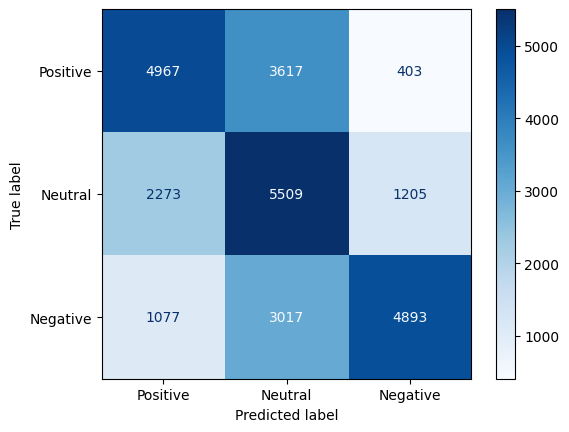

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Neutral", "Negative"])
# display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
disp.plot(cmap='Blues')
plt.show()


Now, let's consider only negative and positive labels.

In [23]:
pred_df = pd.read_csv(out_file)
pred_df.head()

,y_true,y_pred
0,Negative,Negative
1,Negative,Neutral
2,Negative,Negative
3,Negative,Negative
4,Negative,Neutral


In [28]:
y_true = pred_df["y_true"].map({"Positive": 1, "Negative": 0})
y_pred = pred_df["y_pred"].map({"Positive": 1, "Negative": 0})

In [29]:
nan_locations = y_pred[y_pred.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)

nan_locations = y_true[y_true.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)

In [32]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[4893, 1077],
       [ 403, 4967]])